# Este es el Jupyter Notebook que se ha utilizado para probar modelos de Machine Learning con diferentes variables y diferentes transformaciones

In [ ]:
# pip install catboost
# %pip install hyperopt
# %pip install lightgbm

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR, AdaBoostRegressor as ABR, BaggingRegressor as BR
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from catboost import CatBoostRegressor as CBR

In [2]:
from sklearn.model_selection import GridSearchCV  
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from lightgbm import LGBMRegressor as LGBMR
from sklearn.svm import SVR
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor

In [38]:
bnb = pd.read_csv("../data/train_clean3.csv")

In [39]:
pd.set_option('display.max_columns', None)
bnb.head()

,log_price,room_type,cleaning_fee,cancellation_policy,city,host_experience,accommodates,bathrooms,bedrooms,property_type,mean_log_price,neighbourhood_cluster,neighbourhood
0,4.499810,Entire home/apt,1,flexible,NYC,poco_experimentado,2,1.0,1,Apartment,4.594133,6,Astoria
1,3.970292,Private room,1,strict,NYC,experimentado,2,1.0,1,Apartment,4.594133,5,Hamilton Heights
2,4.787492,Entire home/apt,1,moderate,NYC,muy_experimentado,4,1.0,1,Apartment,5.072061,5,Bedford-Stuyvesant
3,4.700480,Entire home/apt,0,moderate,NYC,muy_experimentado,3,1.1,1,Apartment,4.861277,7,Clinton Hill
4,5.192957,Entire home/apt,1,strict,NYC,muy_experimentado,3,1.0,1,Apartment,4.861277,7,Long Island City


In [5]:
bnb.columns

Index(['log_price', 'room_type', 'cleaning_fee', 'cancellation_policy', 'city',
       'host_experience', 'accommodates', 'bathrooms', 'bedrooms',
       'property_type', 'neighbourhood_cluster'],
      dtype='object')

# Matriz de correlaciones 

In [ ]:
plt.figure(figsize=(15, 10))   # 150x100 pixeles

sns.set(style='white')    # estilo blanco

mask=np.triu(np.ones_like(bnb.corr(), dtype=bool))    # mascara para tapar lo de arriba

cmap=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de  colores


sns.heatmap(bnb.corr(),    
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

# Filtro por variables categóricas de interes y numéricas de mayor correlación

In [40]:
cols =['log_price', 'room_type', 'cleaning_fee','city',
      'bathrooms', 'bedrooms',
       'property_type', 'neighbourhood_cluster','accommodates','mean_log_price','neighbourhood']



bnb2 = bnb[cols]

# Matriz de correlaciones definitiva

C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\3409553626.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(bnb2.corr(), dtype=bool))    # mascara para tapar lo de arriba
C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\3409553626.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(bnb2.corr(),


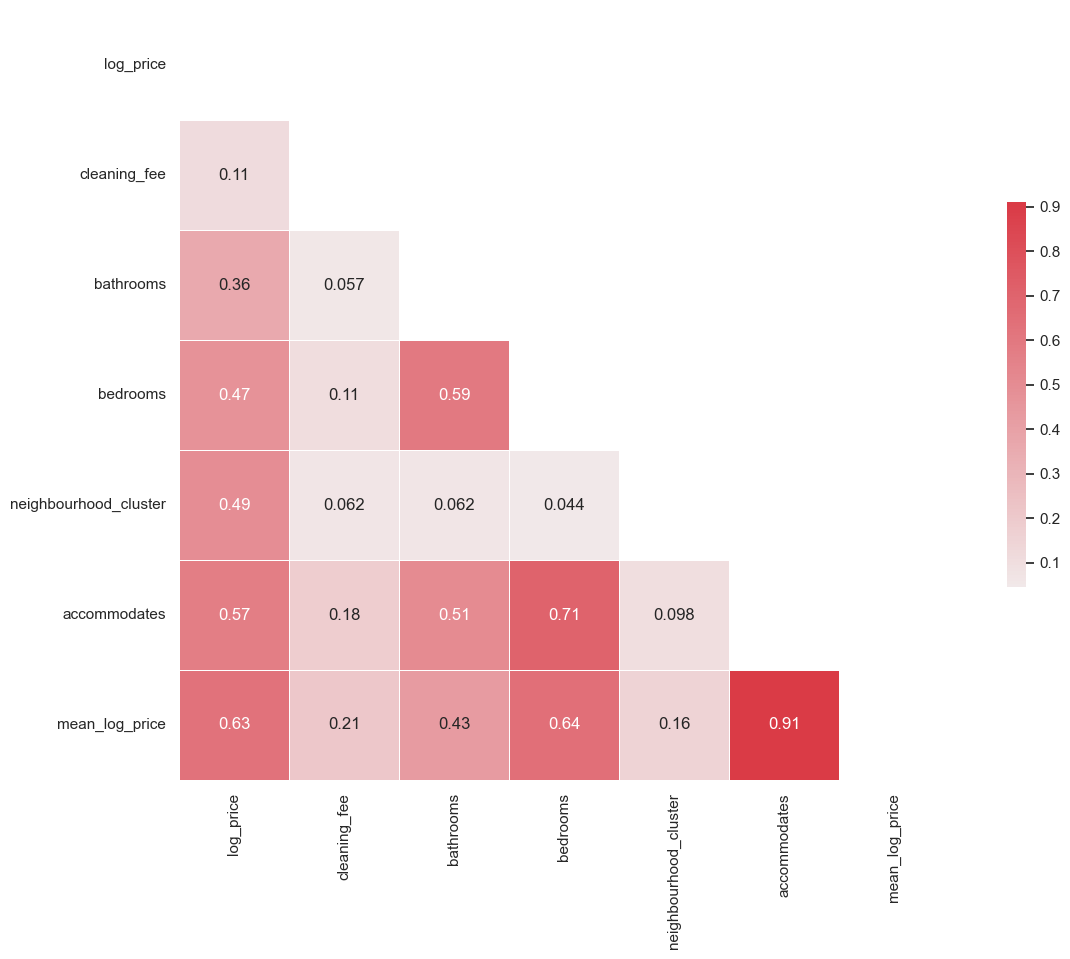

In [27]:
plt.figure(figsize=(15, 10))   # 150x100 pixeles

sns.set(style='white')    # estilo blanco

mask=np.triu(np.ones_like(bnb2.corr(), dtype=bool))    # mascara para tapar lo de arriba

cmap=sns.diverging_palette(0, 10, as_cmap=True)   # paleta de  colores


sns.heatmap(bnb2.corr(),    
           mask=mask,
          cmap=cmap,
          center=0,
          square=True,
          annot=True,
          linewidths=0.5,
          cbar_kws={'shrink': 0.5});

# One hot encoding

In [ ]:

# bnb2 = pd.get_dummies(bnb2, columns=['room_type','city'], drop_first=True)


# Conversión de columnas a categóricas

In [41]:
categorical_columns = ['property_type', 'city', 'room_type','neighbourhood']

# Itera sobre las columnas y conviértelas a categorías
for column in categorical_columns:
    bnb2[column] = bnb2[column].astype('category')


C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\2670564516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnb2[column] = bnb2[column].astype('category')
C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\2670564516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bnb2[column] = bnb2[column].astype('category')
C:\Users\daarr\AppData\Local\Temp\ipykernel_28220\2670564516.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

# Generación de Train y Test

In [42]:
X = bnb2.drop('log_price', axis=1)

y = bnb2.log_price

In [43]:

X_train, X_test, y_train, y_test = tts(X, y, 
                                       train_size=0.8, 
                                       test_size=0.2
                                      ,random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47430, 10), (11858, 10), (47430,), (11858,))

# Normalización y Label encoder

In [ ]:
# escalador = StandardScaler()    # inicia el normalizador
 
# X_train[['bathrooms','bedrooms']] = escalador.fit_transform(X_train[['bathrooms','bedrooms']])   # transforma train

In [ ]:
# X_test[['bathrooms','bedrooms']] = escalador.transform(X_test[['bathrooms','bedrooms']])  # transforma test

In [ ]:

# label = LabelEncoder()

# X_train.city = label.fit_transform(X_train.city)

# X_test.city = label.fit_transform(X_test.city)

# X_train.host_experience = label.fit_transform(X_train.host_experience)

# X_test.host_experience = label.fit_transform(X_test.host_experience)

# X_train.cancellation_policy = label.fit_transform(X_train.cancellation_policy)

# X_test.cancellation_policy = label.fit_transform(X_test.cancellation_policy)

In [44]:
X_train.head()

,room_type,cleaning_fee,city,bathrooms,bedrooms,property_type,neighbourhood_cluster,accommodates,mean_log_price,neighbourhood
8322,Entire home/apt,1,NYC,1.0,2,Loft,8,4,5.253217,Gowanus
9750,Private room,0,NYC,1.0,1,Apartment,7,1,4.226266,Clinton Hill
26187,Entire home/apt,1,LA,1.0,1,Apartment,9,4,5.072061,Hollywood Hills
2211,Entire home/apt,1,Boston,1.0,1,Apartment,7,2,4.594133,East Boston
55503,Entire home/apt,1,Chicago,2.0,2,Apartment,9,6,5.364097,River North


In [49]:
X_test.head()

,room_type,cleaning_fee,city,bathrooms,bedrooms,property_type,neighbourhood_cluster,accommodates,mean_log_price,neighbourhood
21789,Entire home/apt,1,NYC,1.0,2,Apartment,9,4,5.072061,Financial District
13438,Shared room,0,LA,3.0,1,Hostel,5,6,3.030859,Westlake
46523,Private room,1,Chicago,2.0,3,Condominium,5,16,5.572656,Humboldt Park
9902,Entire home/apt,1,LA,2.0,2,House,7,5,5.337610,Mar Vista
38899,Entire home/apt,0,NYC,1.0,2,Apartment,8,3,4.861277,Upper West Side


# Entrenamiento de diversos modelos de Regresión

In [47]:
cbr = CBR(depth = 12, iterations= 300, learning_rate= 0.1) 
cbr.fit(X_train, y_train, cat_features=categorical_columns)

0:	learn: 0.6774298	total: 242ms	remaining: 1m 12s
1:	learn: 0.6394424	total: 553ms	remaining: 1m 22s
2:	learn: 0.6065719	total: 802ms	remaining: 1m 19s
3:	learn: 0.5785605	total: 1.05s	remaining: 1m 17s
4:	learn: 0.5543126	total: 1.5s	remaining: 1m 28s
5:	learn: 0.5331373	total: 1.87s	remaining: 1m 31s
6:	learn: 0.5145474	total: 2.31s	remaining: 1m 36s
7:	learn: 0.4986730	total: 2.75s	remaining: 1m 40s
8:	learn: 0.4851287	total: 3.3s	remaining: 1m 46s
9:	learn: 0.4738995	total: 3.68s	remaining: 1m 46s
10:	learn: 0.4638807	total: 4.11s	remaining: 1m 47s
11:	learn: 0.4556576	total: 4.5s	remaining: 1m 47s
12:	learn: 0.4483659	total: 5s	remaining: 1m 50s
13:	learn: 0.4420357	total: 5.42s	remaining: 1m 50s
14:	learn: 0.4365981	total: 5.88s	remaining: 1m 51s
15:	learn: 0.4320784	total: 6.38s	remaining: 1m 53s
16:	learn: 0.4289302	total: 6.53s	remaining: 1m 48s
17:	learn: 0.4253202	total: 6.93s	remaining: 1m 48s
18:	learn: 0.4222647	total: 7.37s	remaining: 1m 48s
19:	learn: 0.4197230	total: 

158:	learn: 0.3741343	total: 1m 12s	remaining: 1m 4s
159:	learn: 0.3738566	total: 1m 12s	remaining: 1m 3s
160:	learn: 0.3737619	total: 1m 13s	remaining: 1m 3s
161:	learn: 0.3737510	total: 1m 13s	remaining: 1m 2s
162:	learn: 0.3735421	total: 1m 13s	remaining: 1m 2s
163:	learn: 0.3733149	total: 1m 14s	remaining: 1m 1s
164:	learn: 0.3732320	total: 1m 15s	remaining: 1m 1s
165:	learn: 0.3729993	total: 1m 15s	remaining: 1m 1s
166:	learn: 0.3724177	total: 1m 16s	remaining: 1m
167:	learn: 0.3722039	total: 1m 16s	remaining: 1m
168:	learn: 0.3719639	total: 1m 16s	remaining: 59.6s
169:	learn: 0.3717921	total: 1m 17s	remaining: 59.1s
170:	learn: 0.3716348	total: 1m 17s	remaining: 58.8s
171:	learn: 0.3716029	total: 1m 18s	remaining: 58.4s
172:	learn: 0.3715752	total: 1m 18s	remaining: 57.9s
173:	learn: 0.3715090	total: 1m 19s	remaining: 57.4s
174:	learn: 0.3713887	total: 1m 19s	remaining: 57s
175:	learn: 0.3712349	total: 1m 20s	remaining: 56.5s
176:	learn: 0.3709558	total: 1m 20s	remaining: 56.1s
1

In [32]:
# lgbmr = LGBMR(colsample_bytree=0.8, learning_rate=0.1, max_depth=10, n_estimators=500,num_leaves=50, subsample=0.8,force_row_wise=True, n_jobs=8)
# lgbmr.fit(X_train, y_train) 

In [48]:
y_pred5 = cbr.predict(X_test)
print(mse(y_test, y_pred5, squared=False))
# y_pred6 = lgbmr.predict(X_test)
# print(mse(y_test, y_pred6, squared=False))


0.4110024236773752


# Análisis genérico de algunos modelos

In [ ]:
# models = {"mlp_regressor": MLPRegressor(),
#     "random_forest_regressor": RandomForestRegressor(),
#     "gradient_boosting_regressor": GradientBoostingRegressor(),
#     "elastic_net": ElasticNet()}

In [ ]:
# def fit_and_score(models, X_train, X_test, y_train, y_test):
#     """
#     Fits the given machine learning models to the training data and evaluates their performance on the test data.
#     Parameters:
#     - models (dict): A dictionary where keys are model names and values are the corresponding machine learning models.
#     - X_train (array-like): Feature matrix of the training set.
#     - X_test (array-like): Feature matrix of the test set.
#     - y_train (array-like): True labels of the training set.
#     - y_test (array-like): True labels of the test set.
#     Returns:
#     dict: A dictionary where keys are model names and values are their corresponding accuracy scores on the test set.
#     This function takes a dictionary of machine learning models and fits each model to the training data.
#     It then evaluates the performance of each model on the provided test data using the `score` method,
#     and returns a dictionary of model names and their corresponding accuracy scores.
#     """
#     model_scores = {}
#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         model_scores[name] = round(mse(y_test, y_pred, squared=False), 5)
#     return model_scores

In [ ]:
# fit_and_score(models, X_train, X_test, y_train, y_test)

# Busqueda de Hiperparámetros de los modelos de mayor éxito

# GRIDSEARCH PARA rfr

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid
# params = {'n_estimators': [10, 20, 50, 100, 150, 200, 500],
#           'max_depth': [5, 10, 20, 25]}
# modelo = RFR()

# mejor_modelo = grid(modelo, params, X_train, y_train, X_test, y_test)

# Ahora puedes usar mejor_modelo para hacer predicciones u otras operaciones.
# Mejor RMSE en test: 0.44
# Mejor RMSE en train: 0.39
# Mejores parametros: {'max_depth': 10, 'n_estimators': 200}
# Mejor RMSE cv: 0.42

# GRIDSEARCH PARA xgbr

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_xgb(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_xgb
# params_xgb = {'n_estimators': [20, 100, 150, 200, 500],
#               'max_depth': [5, 10, 20, 25],
#               'learning_rate': [0.001, 0.01, 0.1]}
# modelo_xgb = XGBRegressor()

# mejor_modelo_xgb = grid_xgb(modelo_xgb, params_xgb, X_train, y_train, X_test, y_test)
# # Mejor RMSE en test: 0.43
# # Mejor RMSE en train: 0.40
# # Mejores parametros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
# # Mejor RMSE cv: 0.41

# GRIDSEARCH PARA mlp

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_mlp(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_mlp
# params_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#               'activation': ['relu', 'tanh'],
#               'alpha': [0.0001, 0.001, 0.01]}
# modelo_mlp = MLPRegressor()

# mejor_modelo_mlp = grid_mlp(modelo_mlp, params_mlp, X_train, y_train, X_test, y_test)


# GRIDSEARCH PARA LGBMRegressor

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mse(y_true, y_pred)), greater_is_better=False)

# def grid_lgbm(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_lgbm
# params_lgbm = {'n_estimators': [50, 100, 200],
#                'learning_rate': [0.01, 0.1, 0.2],
#                'max_depth': [5, 10, 15],
#                'subsample': [0.8, 0.9, 1.0]}
# modelo_lgbm = LGBMR()

# mejor_modelo_lgbm = grid_lgbm(modelo_lgbm, params_lgbm, X_train, y_train, X_test, y_test)
# # Mejor RMSE en train: 0.39
# # Mejores parametros: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200, 'subsample': 0.8}
# # Mejor RMSE cv: 0.41

# GRIDSEARCH PARA GradientBoostingRegressor

In [ ]:
# # Definir la métrica de RMSE como scorer
# rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# def grid_gb(modelo, params, X_train, y_train, X_test, y_test):

#     g = GridSearchCV(modelo,     # modelo de ML de sklearn
#                      params,     # dictio de params a probar
#                      cv=5,       # cv=cross-validation
#                      return_train_score=True,   # error de entrenamiento
#                      n_jobs=8,                  # usa todos los cores
#                      scoring=rmse_scorer        # métrica de RMSE
#                     )

#     g.fit(X_train, y_train)

#     # ajuste de todos los modelos y combinaciones
#     print('Mejor RMSE en test: {:.2f}'.format(np.abs(g.score(X_test, y_test))))
#     print('Mejor RMSE en train: {:.2f}'.format(np.abs(g.score(X_train, y_train))))
#     print('Mejores parametros: {}'.format(g.best_params_))
#     print('Mejor RMSE cv: {:.2f}'.format(np.abs(g.best_score_)))

#     # Retornar el mejor modelo ajustado
#     return g.best_estimator_

# # Uso de la función grid_gb
# params_gb = {'n_estimators': [50, 100, 200],
#              'learning_rate': [0.01, 0.1, 0.2],
#              'max_depth': [3, 5, 7]}
# modelo_gb = GradientBoostingRegressor()

# mejor_modelo_gb = grid_gb(modelo_gb, params_gb, X_train, y_train, X_test, y_test)

# # Ahora puedes usar mejor_modelo_gb para hacer predicciones u otras operaciones.

# GRIDSEARCH PARA Catboosregressor

In [ ]:
# # Definir el espacio de búsqueda de hiperparámetros para CatBoostRegressor
# param_grid_catboost = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'depth': [4, 6, 8, 10],
# }

# # Crear el modelo CatBoostRegressor
# catboost_model = CBR()

# # Realizar la búsqueda de hiperparámetros
# grid_search_catboost = GridSearchCV(
#     estimator=catboost_model,
#     param_grid=param_grid_catboost,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=8
# )
# grid_result_catboost = grid_search_catboost.fit(X_train, y_train)

# # Obtener los mejores parámetros
# best_params_catboost = grid_result_catboost.best_params_
# print(f"Mejores parámetros para CatBoost: {best_params_catboost}")

# # Obtener el modelo con los mejores parámetros
# best_model_catboost = grid_result_catboost.best_estimator_

# # Evaluación del modelo
# y_pred_catboost = best_model_catboost.predict(X_test)
# rmse_catboost = mse(y_test, y_pred_catboost, squared=False)
# print(f"RMSE en conjunto de prueba: {rmse_catboost}")

# Entrenamiento y testeo de modelos con los hiperparámetros óptimos

In [ ]:
rfr = RFR(max_depth= 10, n_estimators= 200)

rfr.fit(X_train, y_train)

In [ ]:
xgbr = XGBRegressor(
    objective='reg:squarederror',  # Puedes usar 'reg:squaredlogerror' para regresión logarítmica
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200
)

xgbr.fit(X_train, y_train)

In [ ]:
mlp = MLPRegressor(activation= 'tanh', alpha= 0.001, hidden_layer_sizes= (50, 50))

mlp.fit(X_train, y_train)

In [ ]:
gbr = GBR(learning_rate= 0.1, max_depth= 5, n_estimators= 150)    # inicia el modelo


gbr.fit(X_train, y_train)   # entrena el modelo

In [ ]:
y_pred1 = rfr.predict(X_test)
print(mse(y_test, y_pred1, squared=False))
y_pred2 = xgbr.predict(X_test)
print(mse(y_test, y_pred2, squared=False))
y_pred3 = mlp.predict(X_test)
print(mse(y_test, y_pred3, squared=False))
y_pred4 = gbr.predict(X_test)
print(mse(y_test, y_pred4, squared=False))



# Combinación de resultados de diferentes modelos

In [ ]:
modelos = [rfr, xgbr, mlp, gbr,cbr,lgbmr]
predicciones = [modelo.predict(X_test) for modelo in modelos]


def error_total(pesos):
    combinacion_lineal = np.dot(np.array(predicciones).T, pesos)
    return mse(y_test, combinacion_lineal, squared=False)

# Definir límites para los pesos (pueden variar según tus necesidades)
bounds = [(0, 1)] * len(modelos)

# Realizar la optimización heurística
resultado_optimizacion = differential_evolution(error_total, bounds, seed=42)

# Obtener los pesos óptimos
pesos_optimos = resultado_optimizacion.x

# Evaluar el rendimiento con los pesos óptimos
combinacion_lineal_optima = np.dot(np.array(predicciones).T, pesos_optimos)
mse_optimo = mse(y_test, combinacion_lineal_optima, squared=False)

print("Pesos óptimos:", pesos_optimos)
print("MSE óptimo:", mse_optimo)

In [ ]:
# # Definir el espacio de búsqueda de hiperparámetros para CatBoostRegressor
# param_grid_catboost = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'depth': [4, 6, 8, 10],
# }

# # Crear el modelo CatBoostRegressor
# catboost_model = CBR()

# # Realizar la búsqueda de hiperparámetros
# grid_search_catboost = GridSearchCV(
#     estimator=catboost_model,
#     param_grid=param_grid_catboost,
#     cv=3,
#     scoring='neg_mean_squared_error',
#     n_jobs=8
# )
# grid_result_catboost = grid_search_catboost.fit(X_train, y_train)

# # Obtener los mejores parámetros
# best_params_catboost = grid_result_catboost.best_params_
# print(f"Mejores parámetros para CatBoost: {best_params_catboost}")

# # Obtener el modelo con los mejores parámetros
# best_model_catboost = grid_result_catboost.best_estimator_

# # Evaluación del modelo
# y_pred_catboost = best_model_catboost.predict(X_test)
# rmse_catboost = mse(y_test, y_pred_catboost, squared=False)
# print(f"RMSE en conjunto de prueba: {rmse_catboost}")